# Image processing with Markov random fields

Markov random fields are quite good models for image textures as they naturally model local dependencies.

<img src = 'illustrations/markov-random-field-i.pdf' width=100%>


The celebrated Hammersley-Clifford theorem fixes the format in which the corresponding probability distibution must be sought:

\begin{align*}
p[\boldsymbol{x}]=\frac{1}{Z(\omega)}\cdot\exp\Biggl(-\sum_{c\in\textsf{MaxClique}}\Psi_c(\boldsymbol{x}_c,\omega)\Biggr) 
\end{align*} 
where 
* $Z(\omega)$ is a normalising constant
* $\textsf{MaxClique}$ is the set of maximal cliques in the Markov random field
* $\Psi_c$ is defined on the variables $x_i$ in the clique $c$. 

If we define all individual potentials $\Psi_c$ as quadratic forms over $\boldsymbol{x}_c$, the resulting distribution will be a multivariate normal distribution. The latter allows us to obtain analytical solutions for basic inference tasks that are generally doable with complex MCMC simulation algorithms.
The main aim of this tutorial, is to demonstrate the remarkable properties of multivariate normal distribution that provide necessary formulae to get the analytical solution.   


In [195]:
import numpy as np
import pandas as pd
import scipy.stats as stats
import matplotlib.pyplot as plt
import sklearn
import string
import sys

from pandas import Series
from pandas import DataFrame
from typing import List,Tuple

from pandas import Categorical
from pandas.api.types import CategoricalDtype

from tqdm import tnrange#, tqdm_notebook
from sklearn.linear_model import LogisticRegression
from plotnine import *

# Local imports
from common import *
from convenience import *

## I. Toy example. Homogenous MRF for 3 x 3 grid

In the simplest homogenous MRF model each node is influenced by four of its closest neighbours where 

* the deviations from the mean pixel intensity are penalised by $\delta^2 x_{ij}$
* the differeces in the horisontal direction are penalised by $\alpha (x_{ij}-x_{i,j+1})^2$
* the differeces in the vertical direction are penalised by $\beta (x_{ij}-x_{i+1,j})^2$

In the following we are building the inverse covariance matrix for the $3\times 3$ grid depicted below 

<img src = 'illustrations/markov-random-field-ii.pdf' width=100%>

## II. The shape of inverse covariance matrix

As the term $(a-b)^2 = a^2 -2ab + b^2$ we can capture vertical penalities between pairs $x_0, x_3$ and $x_1, x_4$ and $x_2, x_5$ by the matrix

\begin{align*}
V=
\begin{pmatrix}
+1    & \;\;0 & \;\;0 &    -1 & \;\;0 & \;\;0\\
\;\;0 &    +1 & \;\;0 & \;\;0 &    -1 & \;\;0\\
\;\;0 & \;\;0 &    +1 & \;\;0 & \;\;0 &    -1\\
   -1 & \;\;0 & \;\;0 &    +1 & \;\;0 & \;\;0\\
\;\;0 &    -1 & \;\;0 & \;\;0 &    +1 & \;\;0\\
\;\;0 & \;\;0 &    -1 & \;\;0 & \;\;0 &    +1\\
\end{pmatrix}
\end{align*}

if we ignore the scaling factor $\beta$. 
Horizontal penalties between pairs $x_0, x_1$ and $x_3, x_4$ and $x_6,x_7$ are captured by the same matrix if we consider submatrix indexed by $[0,3,6,1,4,7]$. Thus it is straightforward to construct the inverse correlation matrix $S$. 

In [111]:
V = np.identity(6)
np.fill_diagonal(V[:,3:], -1)
np.fill_diagonal(V[3:,:], -1)
DataFrame(V)

,0,1,2,3,4,5
0,1.0,0.0,0.0,-1.0,0.0,0.0
1,0.0,1.0,0.0,0.0,-1.0,0.0
2,0.0,0.0,1.0,0.0,0.0,-1.0
3,-1.0,0.0,0.0,1.0,0.0,0.0
4,0.0,-1.0,0.0,0.0,1.0,0.0
5,0.0,0.0,-1.0,0.0,0.0,1.0


In [123]:
delta = 1
alpha = 2
beta = 2

,0,1,2,3,4,5,6,7,8
0,5.0,-2.0,0.0,-2.0,0.0,0.0,0.0,0.0,0.0
1,-2.0,7.0,-2.0,0.0,-2.0,0.0,0.0,0.0,0.0
2,0.0,-2.0,5.0,0.0,0.0,-2.0,0.0,0.0,0.0
3,-2.0,0.0,0.0,7.0,-2.0,0.0,-2.0,0.0,0.0
4,0.0,-2.0,0.0,-2.0,9.0,-2.0,0.0,-2.0,0.0
5,0.0,0.0,-2.0,0.0,-2.0,7.0,0.0,0.0,-2.0
6,0.0,0.0,0.0,-2.0,0.0,0.0,5.0,-2.0,0.0
7,0.0,0.0,0.0,0.0,-2.0,0.0,-2.0,7.0,-2.0
8,0.0,0.0,0.0,0.0,0.0,-2.0,0.0,-2.0,5.0


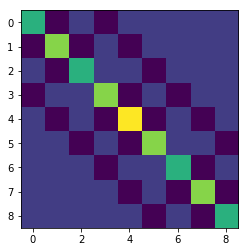

In [128]:
S = delta**2 * np.identity(9)

# Vertical penalties
l = [0, 1, 2, 3, 4, 5]
S[np.ix_(l,l)] += alpha * V 
l = [3, 4, 5, 6, 7, 8]
S[np.ix_(l,l)] += alpha * V 

# Horizontal penalties
l = [0, 3, 6, 1, 4, 7]
S[np.ix_(l,l)] += beta * V 
l = [1, 4, 7, 2, 5, 8]
S[np.ix_(l,l)] += beta * V 

plt.imshow(S)
display(DataFrame(S))

As you can see the resulting matrix is pentadiagonal with quite simple structure and we can easily synthesise it 

In [130]:
def inverse_covariance_matrix(alpha: float, beta:float, delta:float) -> np.array: 
    """
    Given parameters assembles inverse covariance matrix for 3 x 3 grid 
    """
    
    # Intensity deviation penalties
    S = delta**2 * np.identity(9)

    # Vertical penalties
    l = [0, 1, 2, 3, 4, 5]
    S[np.ix_(l,l)] += alpha * V 
    l = [3, 4, 5, 6, 7, 8]
    S[np.ix_(l,l)] += alpha * V 

    # Horizontal penalties
    l = [0, 3, 6, 1, 4, 7]
    S[np.ix_(l,l)] += beta * V 
    l = [1, 4, 7, 2, 5, 8]
    S[np.ix_(l,l)] += beta * V 
    
    return S

Some inverse covariance matrixes with their inverses -- covariance matrices.  

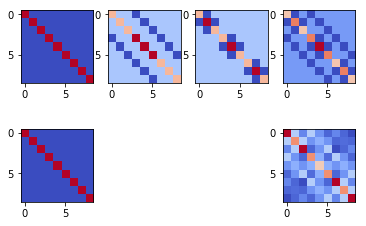

In [148]:
plt.figure(1)
plt.subplot(241)
plt.imshow(inverse_covariance_matrix(0,0,1), cmap='coolwarm')
plt.subplot(242)
plt.imshow(inverse_covariance_matrix(1,0,0), cmap='coolwarm')
plt.subplot(243)
plt.imshow(inverse_covariance_matrix(0,1,0), cmap='coolwarm')
plt.subplot(244)
plt.imshow(inverse_covariance_matrix(1,1,0.5), cmap='coolwarm')
plt.subplot(245)
plt.imshow(np.linalg.inv(inverse_covariance_matrix(0,0,1)), cmap='coolwarm')
plt.subplot(248)
plt.imshow(np.linalg.inv(inverse_covariance_matrix(1,1,.5)), cmap='coolwarm')

It worth noting that the covariance matrix is quite dispersed -- all pixels are correlated with eaxh other.

## III. Texture sampling with multivariate normal distribution

As we know the inverse covariance matrix is enough to determine the entire multivariate normal distribution. The following code generates patches from the $3\times 3$ MRF with different paramaters. 

In [196]:
def sample_mrf(m:int, alpha:float, beta:float, delta:float):
    """
    Samples m x m patches from the MRF specified by alpha, beta, delta.
    
    Aborts if the inverse covariance matrix cannot be inverted correctly. 
    Numeric stability check was taken from 
    https://stackoverflow.com/questions/13249108/efficient-pythonic-check-for-singular-matrix
    """
    
    S = inverse_covariance_matrix(alpha, beta, delta)
    
    if np.linalg.cond(S) > 1/sys.float_info.epsilon:
        print('Ill-conditioned inverse covariance matrix')
        return
    
    distr = stats.multivariate_normal(cov=np.linalg.inv(S))
    patches = distr.rvs(m * m)
    
    X = np.full([4 *  m + 1, 4 * m + 1], np.nan)
    for i in range(m):
        for j in range(m):
            X[i*4+1 : i*4+4, j*4+1 : j*4+4] = patches[i * m + j].reshape(3,3)    
    
    
    cmap=plt.get_cmap('Greys')
    cmap.set_bad(color='Olive')
    plt.imshow(X, cmap=cmap, vmin = -4, vmax = 4)

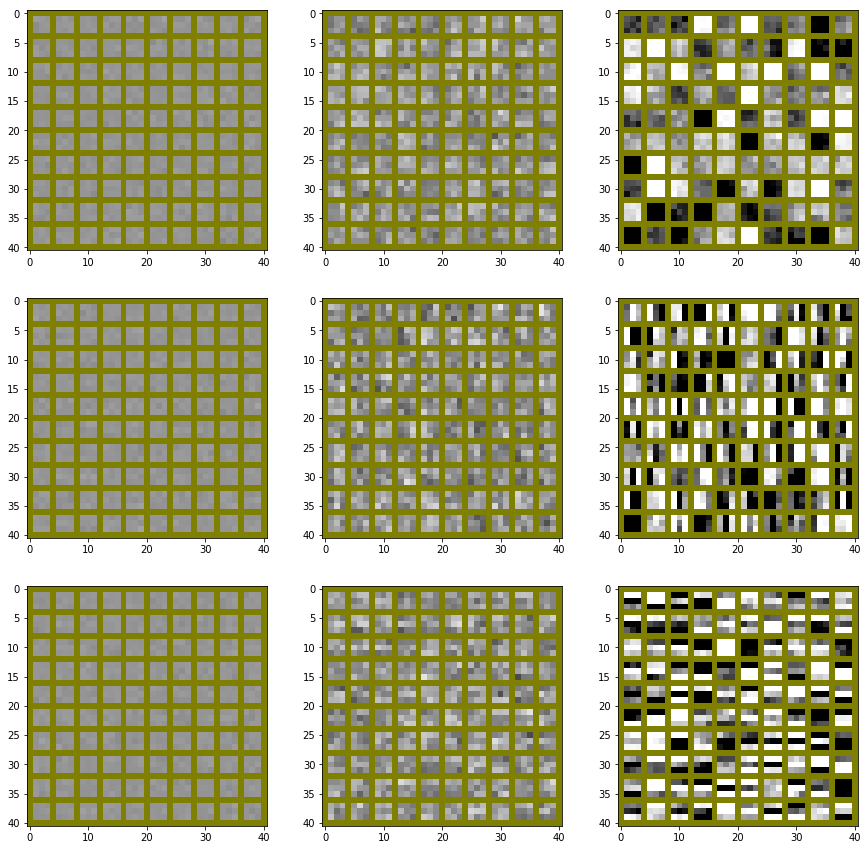

In [212]:
plt.figure(figsize=(15,15))
plt.subplot(331)
sample_mrf(10, 1,1,10)
plt.subplot(332)
sample_mrf(10, 1,1,1)
plt.subplot(333)
sample_mrf(10, 1,1,0.1)

plt.subplot(334)
sample_mrf(10, 1,0,10)
plt.subplot(335)
sample_mrf(10, 1,0,1)
plt.subplot(336)
sample_mrf(10, 1,0,0.1)

plt.subplot(337)
sample_mrf(10, 0,1,10)
plt.subplot(338)
sample_mrf(10, 0,1,1)
plt.subplot(339)
sample_mrf(10, 0,1,0.1)



## IV. Image recovery from few pixels

Suppose that we know the values of $x_0,x_1,x_2$ and want to reconstruct the entire $3\times 3$ grid.
Then $x_3,\ldots,x_8|x_0,\ldots, x_2$ is also a normal distribution and the parameters can be determined from the following lemma

**Lemma**. Assume that $\boldsymbol{x}\sim\mathcal{N}(\boldsymbol{\mu},\boldsymbol{\Sigma})$ with the following decomposiotion

\begin{align*}
\boldsymbol{x}&=
\begin{pmatrix}
\boldsymbol{x}_1\\
\boldsymbol{x}_2
\end{pmatrix}
&
\boldsymbol{\mu}&=
\begin{pmatrix}
\boldsymbol{\mu}_1\\
\boldsymbol{\mu}_2
\end{pmatrix}
&
\boldsymbol{\Sigma}&=
\begin{pmatrix}
\boldsymbol{\Sigma}_{1} & \boldsymbol{\Sigma}_{*} \\
\boldsymbol{\Sigma}_*^T & \boldsymbol{\Sigma}_{2}
\end{pmatrix}
\end{align*}
Then $\boldsymbol{x}_2|\boldsymbol{x}_1\sim\mathcal{N}(\boldsymbol{\mu}_\circ, \boldsymbol{\Sigma}_\circ)$ where the  parameters can be compted as follows

\begin{align*}
\boldsymbol{\mu}_\circ &= \boldsymbol{\mu}_2 + \boldsymbol{\Sigma_*^T}\boldsymbol{\Sigma_1^{-1}}(\boldsymbol{x}_1-\boldsymbol{\mu}_1)
\\
\boldsymbol{\Sigma}_\circ&=\boldsymbol{\Sigma}_2 + \boldsymbol{\Sigma_*^T}\boldsymbol{\Sigma_1^{-1}}\boldsymbol{\Sigma}_*
\end{align*}


In [213]:
S = inverse_covariance_matrix(1, 1, 1)
C = np.linalg.inv(S)

Let us recover the image provided that the top row is $(0,1,0)$.

In [225]:
x1 = np.array([0,1,0])
mu = np.dot(C[3:,:3], np.dot(np.linalg.inv(C[:3,:3]), x1))
Sigma = C[3:, 3:] + np.dot(C[3:,:3], np.dot(np.linalg.inv(C[:3,:3]), C[:3,3:]))
mdisplay([DataFrame(mu), DataFrame(Sigma)], ['$\mu_\circ$', '$\Sigma_\circ$'])

$\mu_\circ$ $\Sigma_\circ$ 
 
 
 0 
 
 
 
 
 0.075862 
 
 
 0.248276 
 
 
 0.075862 
 
 
 0.055172 
 
 
 0.089655 
 
 
 0.055172 
 
 
 
 
 
 0 
 1 
 2 
 3 
 4 
 5 
 
 
 
 
 0.394425 
 0.138424 
 0.067152 
 0.160703 
 0.087685 
 0.051612 
 
 
 0.138424 
 0.323153 
 0.138424 
 0.087685 
 0.124631 
 0.087685 
 
 
 0.067152 
 0.138424 
 0.394425 
 0.051612 
 0.087685 
 0.160703 
 
 
 0.160703 
 0.087685 
 0.051612 
 0.436080 
 0.147537 
 0.066383 
 
 
 0.087685 
 0.124631 
 0.087685 
 0.147537 
 0.354926 
 0.147537 
 
 
 0.051612 
 0.087685 
 0.160703 
 0.066383 
 0.147537 
 0.436080

In [235]:
def sample_mrf_recovery(m:int, alpha:float, beta:float, delta:float, x1: np.array):
    """
    Samples m x m patches from the MRF specified by alpha, beta, delta and the first row.
    
    Aborts if the inverse covariance matrix cannot be inverted correctly. 
    Numeric stability check was taken from 
    https://stackoverflow.com/questions/13249108/efficient-pythonic-check-for-singular-matrix
    """
    
    S = inverse_covariance_matrix(alpha, beta, delta)
    
    if np.linalg.cond(S) > 1/sys.float_info.epsilon:
        print('Ill-conditioned inverse covariance matrix')
        return
    
    C = np.linalg.inv(S)
    
    mu = np.dot(C[3:,:3], np.dot(np.linalg.inv(C[:3,:3]), x1))
    Sigma = C[3:, 3:] + np.dot(C[3:,:3], np.dot(np.linalg.inv(C[:3,:3]), C[:3,3:]))
    
    distr = stats.multivariate_normal(mean=mu, cov=Sigma)
    patches = distr.rvs(m * m)
    
    X = np.full([4 *  m + 1, 4 * m + 1], np.nan)
    for i in range(m):
        for j in range(m):
            X[i*4+1 : i*4+4, j*4+1 : j*4+4] = np.concatenate((x1,patches[i * m + j])).reshape(3,3)    
    
    
    cmap=plt.get_cmap('Greys')
    cmap.set_bad(color='Olive')
    plt.imshow(X, cmap=cmap, vmin = -4, vmax = 4)

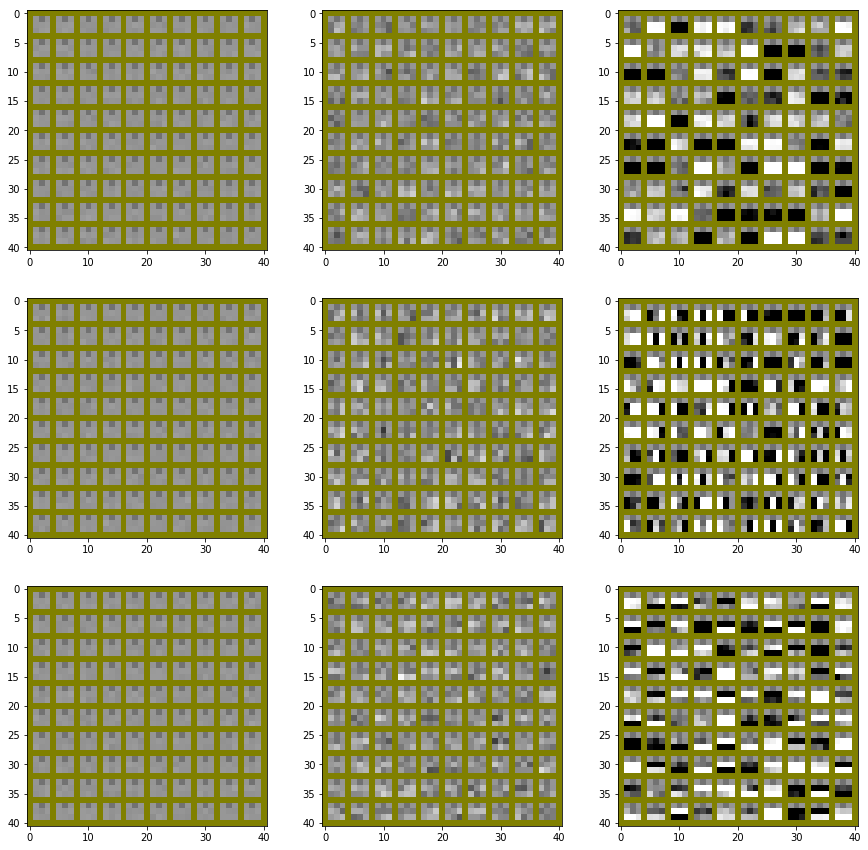

In [241]:
x1 = np.array([0,1,0])

plt.figure(figsize=(15,15))
plt.subplot(331)
sample_mrf_recovery(10, 1,1,10, x1)
plt.subplot(332)
sample_mrf_recovery(10, 1,1,1,  x1)
plt.subplot(333)
sample_mrf_recovery(10, 1,1,0.1, x1)

plt.subplot(334)
sample_mrf_recovery(10, 1,0,10, x1)
plt.subplot(335)
sample_mrf_recovery(10, 1,0,1, x1)
plt.subplot(336)
sample_mrf_recovery(10, 1,0,0.1, x1)

plt.subplot(337)
sample_mrf_recovery(10, 0,1,10, x1)
plt.subplot(338)
sample_mrf_recovery(10, 0,1,1, x1)
plt.subplot(339)
sample_mrf_recovery(10, 0,1,0.1, x1)


## V. Parameter fitting

The simplest way to fit the model parameters $\alpha, \beta, \delta$ is to choose enough independent $3\times 3$ patches and find parameters wich minimise the log-likelihood of the data. The most naive way is to fix some parameter grid for $\alpha, \beta, \delta$ and compute log-likelihood directly with [`multivariate_normal.logpdf`](https://docs.scipy.org/doc/scipy-0.14.0/reference/generated/scipy.stats.multivariate_normal.html) for each patch and see for which parameter set the sum of log-likelihoods is the smallest. 
You can be slightly more efficient and use [hill climing](https://en.wikipedia.org/wiki/Hill_climbing) to see where to jump form the current solution $(\alpha,\beta,\delta)$.     

Note that we know the likelihood 

\begin{align*}
p[X|\alpha,\beta,\delta]\propto \exp\Biggl(
\alpha\cdot\sum_{i=1}^{m-1}\sum_{j=1}^n (x_{i,j}-x_{i+1,j})^2
+\beta\cdot\sum_{i=1}^{m}\sum_{j=1}^{n-1} (x_{i,j}-x_{i,j+1})^2
+\delta^2 \sum_{i=1}^m\sum_{j=1}^n x_{ij}^2
\Biggr)
\end{align*}
up to a constant 

\begin{align*}
c(\alpha,\beta,\delta)=\frac{1}{(2\pi)^{\frac{nm}{2}}\cdot \det \Sigma}=\frac{1}{(2\pi)^{\frac{nm}{2}}}\cdot \det \Sigma^{-1}
\end{align*}

that depends on inverse covariance matrix $\Sigma^{-1}(\alpha,\beta,\delta)$ and thus getting the exact analytical solution is much harder than for typical maximum likelihood fitting. 
As we work with a small $3\times 3$ images it is still possible to compute the determinant of the  $9\times 9$ inverse covariance matrix analytically and get an equation for findind the model parameters.

This method has clear limits, it is almost impossible to lift this approach to a typical sizes of meaningful textures that are at least $32\times 32$ big. Fortunately there is another loop hole provided by the chain rule

\begin{align*}
y=g(f_1(x),f_2(x),\ldots, f_k(x))
\qquad\Longrightarrow\qquad
\frac{\partial y}{\partial x}=\sum_{i=1}^k \frac{\partial g(u_1,\ldots,u_k)}{\partial u_i}\biggl|_\boldsymbol{u_*}\cdot  \frac{\partial f_i(x)}{\partial x}
\end{align*}

where $\boldsymbol{u}_*=(f_1(x),\ldots,f_k(x))$. In our case, the log-likelihood

\begin{align*}
\mathcal{L}(\boldsymbol{\Sigma},\boldsymbol{\mu})=const +\frac{d}{2}\cdot \ln\det(\boldsymbol{\Sigma}^{-1}) 
-\sum_{i=1}^m\frac{(\boldsymbol{x}_i-\boldsymbol{\mu})^T \boldsymbol{\Sigma}^{-1}(\boldsymbol{x}_i-\boldsymbol{\mu})}{2}
\end{align*}
of a $d$ dimensional multivariate normal distribution has known gradient with respect to the  unconstrained inverse covariance matrix $\boldsymbol{\Sigma}^{-1}$:

\begin{align*}
\frac{\partial\mathcal{L}}{\partial(\boldsymbol{\Sigma}^{-1})}
&=\frac{d}{2}\cdot\boldsymbol{\Sigma}^{T} -\sum_{i=1}^m\frac{(\boldsymbol{x}_i-\boldsymbol{\mu})^T (\boldsymbol{x}_i-\boldsymbol{\mu})}{2}
\end{align*}

and thus we can compute partial derivatives 

\begin{align*}
\frac{\partial\mathcal{L}}{\partial \alpha}, 
\frac{\partial\mathcal{L}}{\partial \beta},
\frac{\partial\mathcal{L}}{\partial \delta}
\end{align*}

using the chain rule. However there is still one complication as we need to compute partial derivatives 

\begin{align*}
\frac{\partial \boldsymbol{\Sigma}^{-1}}{\partial \alpha},
\frac{\partial \boldsymbol{\Sigma}^{-1}}{\partial \beta}
\frac{\partial \boldsymbol{\Sigma}^{-1}}{\partial \delta}
\end{align*}

However, as the matrix $\boldsymbol{\Sigma}^{-1}$ has a simple structure this can be done for all image sizes. 

## VI. Gibbs sampling

Note that in principle, we can always compute covariance matrix form the inverse covariance matrix. 
However, this quickly becomes infeasible if image sizes go beyound $32\times 32$ and we need a method for sampling images without the inversion.
This can be done with [Gibbs sampling](https://en.wikipedia.org/wiki/Gibbs_sampling) algorithm that iteratively updates individual pixels $x_{ij}$ until sufficiently many iterations are carried out and we have an image that comes form the distribution very close to our target distribution.

The Gibbs samplin algorithm adjusted to our problem is following

* Initialize starting values of $x_{i,j}$ for $i \in \{1,\ldots, m\}$ and $j\in\{1,\ldots,n\}$.
* Repeat until convergence
  * Pick an order of the $m × n$ variables and for each variable $x_{i,j}$ do
     * Sample $x_{i,j}$ based on $p[x_{i,j}|\mathsf{Neighbours}(x_{i,j})]$.
     * Update the value $y_{i,j}$ accordingly. 
     
Note that if we fix known pixels $x_{ij}$, the algorithm provides a reconstruction.

In be quite tricky to determine whether the number of iterations is sufficient or not and the number of iterations can be quite large -- sometimes around one million. You can try with 1000 iterations.

# Homework

## 2.1 Medium-scale modelling of textures (<font color='red'>1p</font>)

Images of sizes $3\times 3$ are not large enough to see the true texture generated by the simple homogenous Markov field. 
Adjust the model for $16\times 16$ and $32\times 32$ images and syntehsise some textures with different $\alpha,\beta, \delta$ parameters.
Note that we can set $\delta=1$ as by scaling the pixel intensities  by $\sqrt{c}$ we scale the entire inverse covariance matrix by the factor of $c$.


## 2.2 Higer order models for textures* (<font color='red'>3p</font>) 

The simple 4 element neighbourhood cannot capture more complex dependencies between pixel intensities. The following homogenous model 

<img src = 'illustrations/markov-random-field-iii.pdf' width=100%>

is the next natural model that also penalises diagonal differences. Express the corresponding inverse covariance matrix and sample images from the corresponding distribution. As the cliques now have three nodes you can define more complex quadratic dependencies. corresponding inverse covariance matrix and sample images from the corresponding distribution. What is the minimal set of parameters if we ignore global scaling ot the pixel intensities. 


## 2.3 Medium-scale reconstruction of textures (<font color='red'>2p</font>) 

Images of sizes $3\times 3$ are not large enough to see the true texture generated by the simple homogenous Markov field. 
Adjust the model for $16\times 16$ and $32\times 32$ images and syntehsise some textures with different $\alpha,\beta, \delta$ parameters.
Note that we can set $\delta=1$ as by scaling the pixel intensities  by $\sqrt{c}$ we scale the entire inverse covariance matrix by the factor of $c$.
* Adjust the image recovery procedure so that the image is restored form a single row (<font color='red'>**1p**</font>). To see how good is the image reconstruction sample original image form the model, keep the upper row and synthesise several continuations.

* Adjust the image recovery procedure so that it can handle any configuration of seed pixel (and not the upper) row.  To see how good is the image reconstruction sample original image form the model, keep $25, 50, 75\%$ pixels in random locations and synthesise several continuations (<font color='red'>**1p**</font>).


## 2.4 Naive parameter fitting with grid search (<font color='red'>1p</font>)

Try to fit the parameters of the simple homogenous Markov random field by sampling non-overlapping $3\times 3$ patches from three different images 
* [`carpet.jpg`](./data/carpet.jpg), [`hair.jpg`](./data/hairt.jpg), [`moss.jpg`](./data/moss.jpg)

Use naive grid search or hill climing to fit the model to each image, see if there are differences in the models:

* Compare is the stucture of inverse covariance matrices.
* Test whether different models give higher likelihood scores to the patches coming from their image.


## 2.5 Precise analytical parameter fitting* (<font color='red'>1p</font>) 

Consider the simple homogenous Markov random field by sampling non-overlapping $3\times 3$ patches.
* Derive analytical formulae for the gradients $\frac{\partial\mathcal{L}}{\partial \alpha}$, $\frac{\partial\mathcal{L}}{\partial \beta}$ and $
\frac{\partial\mathcal{L}}{\partial \delta}$ and find the analytiocal solution that maximise the data log-lihelihood.
* Try to fit the parameters by sampling non-overlapping $3\times 3$ patches from three different images 
  * [`carpet.jpg`](./data/carpet.jpg), [`hair.jpg`](./data/hairt.jpg), [`moss.jpg`](./data/moss.jpg)
* Compare results with the outcomes of the previous exercise. They should be quite close to each other.


## 2.6 Precise parameter fitting over large image* (<font color='red'>5p</font>)

The previous solution considers only subset of all available patches and thus ignores lots of correlations between pixels. To solve this there are two options

* First, we can extract all subpatches so that the corresponding loglikelihood function is identical up to the normalising constant. Then we can treat all these images as indepenedent and compute the maximal likelihood estimate for parameters $\alpha,\beta,\delta$ (<font color='red'>**1p**</font>).
* Second, we can try to minimize the true loglikelihood. We can do it by minimising the true loglikelihood of the image. This can be none with the grid search (<font color='red'>**1p**</font>) or by using analytical solution (<font color='red'>**2p**</font>).    

Fit the simple homogenous Markov fiels model to the data: [`carpet.jpg`](./data/carpet.jpg), [`hair.jpg`](./data/hairt.jpg), [`moss.jpg`](./data/moss.jpg) and compare the results.

**Extra task:**
Fit higer more complex homogenous Markov field model to the data and compare how well these models capture the texture by synthesising $16\times 16$ $32\times 32$ patches and testing how well models can discriminate between patches from different images (<font color='red'>**5p**</font>).


# Some python modules that might be useful for analytical derivation

In [3]:
from sympy import Matrix
from sympy import Symbol


In [7]:
a = Symbol('a')
b = Symbol('b')
A = Matrix([[1,a,0], [a,1,a],[0,a,1]])

In [8]:
A.det()

-2*a**2 + 1

In [10]:
A2 = Matrix([[1,a,0, b,0,0], [a,1,a, 0,b,0],[0,a,1,0,0, b],[b, 0,0,1,a,0], [0,b,0,a,1,a],[0,0,b,0,a,1]])
display(A2)

Matrix([
[1, a, 0, b, 0, 0],
[a, 1, a, 0, b, 0],
[0, a, 1, 0, 0, b],
[b, 0, 0, 1, a, 0],
[0, b, 0, a, 1, a],
[0, 0, b, 0, a, 1]])

In [11]:
A2.det()

-4*a**4*b**2 + 4*a**4 + 4*a**2*b**4 - 4*a**2 - b**6 + 3*b**4 - 3*b**2 + 1

In [68]:
A3 = Matrix([
    [1,a,0,b,0,0,0,0,0], 
    [a,1,a,0,b,0,0,0,0],
    [0,a,1,0,0,b,0,0,0],
    [b,0,0,1,a,0,b,0,0], 
    [0,b,0,a,1,a,0,b,0],
    [0,0,b,0,a,1,0,0,b],
    [0,0,0,b,0,0,1,a,0],
    [0,0,0,0,b,0,a,1,a],
    [0,0,0,0,0,b,0,a,1]])
display(A3)

Matrix([
[1, a, 0, b, 0, 0, 0, 0, 0],
[a, 1, a, 0, b, 0, 0, 0, 0],
[0, a, 1, 0, 0, b, 0, 0, 0],
[b, 0, 0, 1, a, 0, b, 0, 0],
[0, b, 0, a, 1, a, 0, b, 0],
[0, 0, b, 0, a, 1, 0, 0, b],
[0, 0, 0, b, 0, 0, 1, a, 0],
[0, 0, 0, 0, b, 0, a, 1, a],
[0, 0, 0, 0, 0, b, 0, a, 1]])

In [69]:
A3.row_op(1, lambda v, j: v - a * A3[0, j]); 
A3

Matrix([
[1,         a, 0,    b, 0, 0, 0, 0, 0],
[0, -a**2 + 1, a, -a*b, b, 0, 0, 0, 0],
[0,         a, 1,    0, 0, b, 0, 0, 0],
[b,         0, 0,    1, a, 0, b, 0, 0],
[0,         b, 0,    a, 1, a, 0, b, 0],
[0,         0, b,    0, a, 1, 0, 0, b],
[0,         0, 0,    b, 0, 0, 1, a, 0],
[0,         0, 0,    0, b, 0, a, 1, a],
[0,         0, 0,    0, 0, b, 0, a, 1]])

In [70]:
A3.col_op(1, lambda v,i: v - a *  A3[i,0]) 
A3

Matrix([
[1,         0, 0,    b, 0, 0, 0, 0, 0],
[0, -a**2 + 1, a, -a*b, b, 0, 0, 0, 0],
[0,         a, 1,    0, 0, b, 0, 0, 0],
[b,      -a*b, 0,    1, a, 0, b, 0, 0],
[0,         b, 0,    a, 1, a, 0, b, 0],
[0,         0, b,    0, a, 1, 0, 0, b],
[0,         0, 0,    b, 0, 0, 1, a, 0],
[0,         0, 0,    0, b, 0, a, 1, a],
[0,         0, 0,    0, 0, b, 0, a, 1]])